In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

In [2]:
HOME=os.path.expanduser("~")

In [3]:
datadirs=glob(os.path.join(HOME,'qregress/./16qubit/*/A2_Hadamard/A2_Hadamard_results.json'))+[os.path.join(HOME,'qregress/BSE-calc-test/16qubit/A2_Hadamard/A2_Hadamard_results.json')]

In [4]:
dfs=[]
for i in datadirs:
    with open(i,'r') as g:
        data = json.load(g)
    df = pd.DataFrame.from_dict(data)
    name = os.path.basename(os.path.dirname(os.path.dirname(i)))
    if "RUD"  in name:
        df['RUD']=int(name.replace("RUD",""))
        df['AL']=1
        # df['RUD'] = 
    elif "AL" in name:
        df['RUD']=1
        df['AL']=name.replace("AL","")
    else:
        df['RUD']=1
        df['AL']=1
    dfs.append(df)
    
stacked = pd.concat(dfs)

In [5]:
stacked

,MSE_train,R2_train,MAE_train,MSE_test,R2_test,MAE_test,RUD,AL
0,748.147716,0.002777,19.807104,762.369482,0.014043,20.074514,1,1


In [6]:


# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


device='qulacs.simulator'
num_qubits=5
device = qml.device(device, wires=num_qubits)


In [7]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))

In [8]:
def get_depth(enc,var,rud,features,parameters):
    circuit_gates=0
    circuit_depth=0
    for i in range(rud):
        params = initial_parameters.reshape(rud,-1)[i]
        
        encoder_specs=qml.specs(qml.QNode(encoder,device,expansion_strategy='device'))(features, wires=range(num_qubits))['resources']
        var_specs=qml.specs(qml.QNode(variational,device,expansion_strategy='device'))(params, wires=range(num_qubits))['resources']

        circuit_gates+=var_specs.num_gates + encoder_specs.num_gates
        circuit_depth+=var_specs.depth + encoder_specs.depth
    return circuit_gates,circuit_depth

In [9]:


# draw_encoder = qml.draw_mpl(qml.QNode(ENCODER_LIST['IQP'],device),level=3)
# draw_encoder(np.random.rand(num_qubits), range(num_qubits))

In [10]:
results={}
flat_results=[]
for d in [3, 5]:
    results[d]={}
    for a in ['AL','RUD']:
        results[d][a]={}
        if a=='AL':
            LAYERS=d
            re_upload_depth=1
        else:
            LAYERS=1
            re_upload_depth=d
            
        for p in ["A2_Hadamard"]:
            results[d][a][p]={}
            depth_path = os.path.join("./16qubit/",''.join((str(d),a)),p)
            if os.path.exists(depth_path):
                with open(os.path.join(depth_path,f'{p}_results.json'),'r') as f:
                    results_dict=json.load(f)
                
                
            ENCODER, ANSATZ = p.split('_')
            # print(ENCODER, ANSATZ)
            encoder = ENCODER_LIST[ENCODER]
            variational=ANSATZ_LIST[ANSATZ]
            variational.layers = LAYERS
            variational.set_wires(range(num_qubits))
     

            num_params = variational.num_params * re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            feat = generator.uniform(-1, 1, num_qubits)
            
            qnode = qml.QNode(circuit, device)        
            circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

            circuit_gates,circuit_depth= get_depth(encoder,variational,re_upload_depth,feat,initial_parameters)
            # print(circuit_specs.num_gates,circuit_specs.depth)
            # print(circuit_gates,circuit_depth)
            
            # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
            # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
            # plt.show()
            # print(variational.layers)
            # print()
            with open(os.path.join(depth_path,'model_log.csv'),'r') as f:
                # Create df
                timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
                # Get time between iterations and get the mean time
                timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
                
            print(d,a,p,results_dict['MAE_train'],results_dict['MAE_test'])
            results[d][a][p]={'R2_train':results_dict['R2_train'],'R2_test':results_dict['R2_test'],'num_gates':circuit_gates,'depth':circuit_depth,'mean_iter':timedf['Iter time'].mean()}
            if a=='AL':
                flat_results.append((d,1,p,results_dict['R2_train'],results_dict['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            else:
                flat_results.append((1,d,p,results_dict['R2_train'],results_dict['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            

3 AL A2_Hadamard 19.984908162802423 20.495342385045966
3 RUD A2_Hadamard 23.131813468939853 23.022589029109096
5 AL A2_Hadamard 19.737399466096242 20.123435255888324
5 RUD A2_Hadamard 18.147164155256 18.173727474826954


/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:265: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/workflow/qnode.py:486: PennyLaneDeprecationWarning: The 'expansion_strategy' attribute is deprecated and will be removed  in version 0.39. For full control over the stage to which the tape is constructed, use the 'pennylane.workflow.construct_batch' function.
  warnings.warn(
/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:265: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unint

In [11]:
for p in ["A2_Hadamard"]:
    with open(f'../BSE-calc-test/16qubit/{p}/{p}_results.json','r') as f:
        og_results=json.load(f)
        
    ENCODER, ANSATZ = p.split('_')
    # print(ENCODER, ANSATZ)
    encoder = ENCODER_LIST[ENCODER]
    variational=ANSATZ_LIST[ANSATZ]

    LAYERS=1
    re_upload_depth=1
    variational.layers = LAYERS
    variational.set_wires(range(num_qubits))
    

    num_params = variational.num_params * re_upload_depth
    generator = np.random.default_rng(12958234)
    initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
    feat = generator.uniform(-1, 1, num_qubits)
    
    qnode = qml.QNode(circuit, device)   

    # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
    # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
    # plt.show()
    
    circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

    circuit_gates,circuit_depth= get_depth(encoder,variational,1,feat,initial_parameters)
    
    with open(os.path.join(f"../BSE-calc-test/16qubit/{p}",'model_log.csv'),'r') as f:
        # Create df
        timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
        # Get time between iterations and get the mean time
        timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
    print(p,og_results['MAE_train'],og_results['MAE_test'])
    flat_results.append((1,1,p,og_results['R2_train'],og_results['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))

A2_Hadamard 19.807103607588473 20.07451383812292


/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:265: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/workflow/qnode.py:486: PennyLaneDeprecationWarning: The 'expansion_strategy' attribute is deprecated and will be removed  in version 0.39. For full control over the stage to which the tape is constructed, use the 'pennylane.workflow.construct_batch' function.
  warnings.warn(


In [12]:
results

{3: {'AL': {'A2_Hadamard': {'R2_train': -0.004501672089211484,
    'R2_test': -0.0032764951116888152,
    'num_gates': 52,
    'depth': 16,
    'mean_iter': nan}},
  'RUD': {'A2_Hadamard': {'R2_train': -0.2115105089060627,
    'R2_test': -0.16047496817029283,
    'num_gates': 72,
    'depth': 24,
    'mean_iter': 623.0}}},
 5: {'AL': {'A2_Hadamard': {'R2_train': 0.11132372464569906,
    'R2_test': 0.10561748300337737,
    'num_gates': 80,
    'depth': 24,
    'mean_iter': nan}},
  'RUD': {'A2_Hadamard': {'R2_train': 0.20266179130458695,
    'R2_test': 0.21643069937036485,
    'num_gates': 120,
    'depth': 40,
    'mean_iter': nan}}}}

In [13]:
df = pd.DataFrame(flat_results,columns=['AL','RUD','pairs','R2 Train','R2 Test','num_gates','depth','mean_iter'])

In [14]:
df.sort_values(by=['R2 Train','R2 Test'])

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter
1,1,3,A2_Hadamard,-0.211511,-0.160475,72,24,623.0
0,3,1,A2_Hadamard,-0.004502,-0.003276,52,16,NaN
4,1,1,A2_Hadamard,0.002777,0.014043,24,8,NaN
2,5,1,A2_Hadamard,0.111324,0.105617,80,24,NaN
3,1,5,A2_Hadamard,0.202662,0.216431,120,40,NaN


In [15]:
trash=pd.read_csv('./16qubit/3AL/A2_Hadamard/A2_Hadamard_predicted_values.csv',index_col=0)

In [16]:
trash

,Predicted,Reference
Data,,
Train,[92.17544460331327],[125.53]
Train,[89.28152186199995],[85.28]
Train,[89.09412267255591],[83.06]
Train,[89.72914024473259],[156.44]
Train,[92.2726918428474],[125.92]
...,...,...
Test,[94.95373341707135],[123.26]
Test,[92.52640733176787],[65.94]
Test,[92.30939530377914],[89.35]


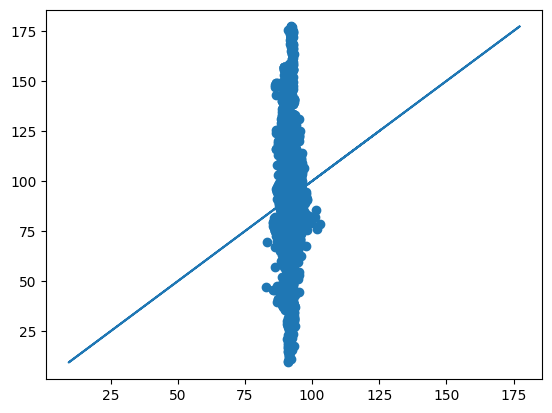

In [17]:
plt.scatter([float(i.strip('[]')) for i in trash['Predicted']],[float(i.strip('[]')) for i in trash['Reference']])
plt.plot([float(i.strip('[]')) for i in trash['Reference']],[float(i.strip('[]')) for i in trash['Reference']])

In [18]:
df['diff']=(df['R2 Train']-df['R2 Test']).abs()

In [19]:
base = df[(df["AL"]==1)&(df["RUD"]==1)]['R2 Train']

In [20]:
df[(df["AL"]!=1)|(df["RUD"]!=1)]

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter,diff
0,3,1,A2_Hadamard,-0.004502,-0.003276,52,16,NaN,0.001225
1,1,3,A2_Hadamard,-0.211511,-0.160475,72,24,623.0,0.051036
2,5,1,A2_Hadamard,0.111324,0.105617,80,24,NaN,0.005706
3,1,5,A2_Hadamard,0.202662,0.216431,120,40,NaN,0.013769


In [21]:
df.sort_values(by=['R2 Train','R2 Test'])

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter,diff
1,1,3,A2_Hadamard,-0.211511,-0.160475,72,24,623.0,0.051036
0,3,1,A2_Hadamard,-0.004502,-0.003276,52,16,NaN,0.001225
4,1,1,A2_Hadamard,0.002777,0.014043,24,8,NaN,0.011266
2,5,1,A2_Hadamard,0.111324,0.105617,80,24,NaN,0.005706
3,1,5,A2_Hadamard,0.202662,0.216431,120,40,NaN,0.013769


In [22]:
100*((df[(df["AL"]!=1)|(df["RUD"]!=1)]['R2 Train'] - base.values)/base.values)

0    -262.091895
1   -7715.867732
2    3908.438005
3    7197.251587
Name: R2 Train, dtype: float64

In [23]:
df['AL_RUD']=[f"({AL},{RUD})" for AL,RUD in df[['AL','RUD']].values]

In [24]:
# sns.barplot(data=df.rename(columns={'R2 Train':'Train','R2 Test':'Test'}).melt(id_vars=['AL_RUD'], value_vars=['Train','Test']),x='variable',y='value',hue='AL_RUD',palette=sns.color_palette('Paired',5))
# plt.ylabel('R$^{2}$ (kcal/mol)')
# plt.xlabel('')
# plt.title('BSE16: A2_Hadamard')
# plt.legend(bbox_to_anchor=(1.05, 1.0),title='(AL,RUD)')
# plt.ylim(-0.3,0.3)
# plt.tight_layout()
# plt.savefig(os.path.join(HOME,'qregress/images/BSE/','BSE16_RUDAL.png'),dpi=300,bbox_inches='tight')
# plt.show()

0.0027772345366146034
0.014043307945032502
-0.2115105089060627
-0.16047496817029283
0.20266179130458695
0.21643069937036485
-0.004501672089211484
-0.0032764951116888152
0.11132372464569906
0.10561748300337737
0
0
0
0
0


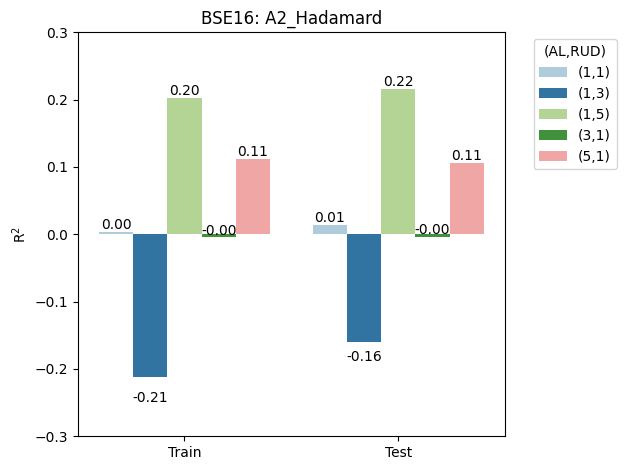

In [25]:

ax = sns.barplot(data=df.rename(columns={'R2 Train':'Train','R2 Test':'Test'}).melt(id_vars=['AL_RUD'], value_vars=['Train','Test']).sort_values(by='AL_RUD'),x='variable',y='value',hue='AL_RUD',palette=sns.color_palette('Paired',5))
for bar in ax.patches:
    height = bar.get_height()
    print(height)
    if height<0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + (height * 0.20),
            f'{height:.2f}',  # Format the label as desired
            ha='center',
            va='bottom',
        )
    elif height>0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',  # Format the label as desired
            ha='center',
            va='bottom',
        )        
plt.ylabel('R$^{2}$ ')
plt.xlabel('')
plt.title('BSE16: A2_Hadamard')
# plt.title('DDCC: A2_HWE-CNOT')
plt.legend(bbox_to_anchor=(1.05, 1.0),title='(AL,RUD)')
plt.ylim(-0.3,0.3)
plt.tight_layout()
plt.savefig(os.path.join(HOME,'qregress/images/BSE/sixteenqubit/BSE16_RUDAL.png'),dpi=300,bbox_inches='tight')
plt.show()

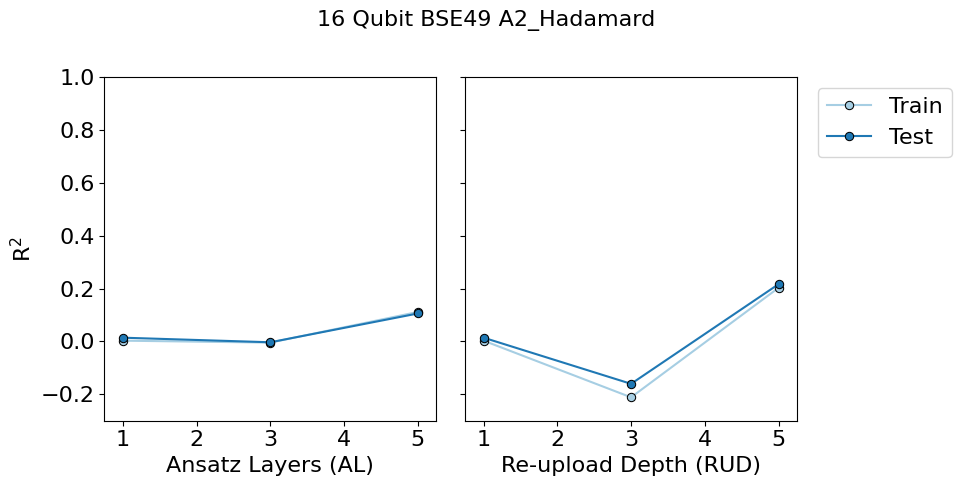

In [33]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

melteddf = df.rename(columns={'R2 Train':'Train','R2 Test':'Test'}).melt(id_vars=['AL','RUD'], value_vars=['Train','Test'])

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.lineplot(melteddf[melteddf['RUD']==1],x='AL',y='value',hue='variable',ax=ax1,palette=sns.color_palette('Paired',2),marker='o', markeredgecolor='black')
sns.lineplot(melteddf[melteddf['AL']==1],x='RUD',y='value',hue='variable',ax=ax2,palette=sns.color_palette('Paired',2),marker='o', markeredgecolor='black')
ax1.set_ylim(-0.3,1)
ax1.set_ylabel("R$^{2}$")
ax1.set_xlim(0.75,5.25)
ax1.set_xticks(np.arange(1,6))
ax1.set_xticklabels(np.arange(1,6))
ax2.set_xlim(0.75,5.25)
ax2.set_xticks(np.arange(1,6))
ax2.set_xticklabels(np.arange(1,6))

ax1.set_xlabel("Ansatz Layers (AL)")
ax2.set_xlabel("Re-upload Depth (RUD)")
# Remove legends from individual plots
ax1.get_legend().remove()
ax2.get_legend().remove()
fig.suptitle('16 Qubit BSE49 A2_Hadamard')
# Global legend
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(HOME,'qregress/images/BSE/sixteenqubit/BSE16_RUDAL_lineplot.png'),dpi=300,bbox_inches='tight')
plt.show()

In [31]:
np.arange(1,6)

array([1, 2, 3, 4, 5])